In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from train_analysis_net import get_model, get_AFX_Chain, get_loaders, get_fx_list, Mel, get_datasets
import os
import librosa
import scipy.io
import audio_quality_estimation

from IPython.display import Audio

cm = 1/2.54

cuda:0


In [2]:
def dB20(x):
    return 20*np.log10(np.abs(x))

def RMS(x):
    return np.sqrt(np.sum(np.square(np.abs(x))))

device = 'cuda:0'
sr_hz = 44100

## Parameters

In [3]:
encoder_type = "time_frequency"
afx="peq"
sfx="peq"
loss_type="mel"
prefix=''
suffix=''

SFX_chain = get_fx_list(afx, synthesis_ranges_dict_path="configs/synthesis_controls_ranges.yaml")





In [4]:

batch_size=1
AFX_Chain = get_AFX_Chain(model_str=afx)

controller_mel=get_model(AFX_Chain=AFX_Chain, encoder_type=encoder_type).to(device).eval()
experience_name = f"quality/{prefix}_SFX_{sfx}_AFX_{afx}_ENC_{encoder_type}_LOSS_mel_{suffix}"
controller_mel.load_state_dict(
        torch.load(os.path.join('/tsi/data_doctorants/peladeau', 'trained_models', f'{experience_name}.pt'))
    )

controller_par=get_model(AFX_Chain=AFX_Chain, encoder_type=encoder_type).to(device).eval()
experience_name = f"quality/{prefix}_SFX_{sfx}_AFX_{afx}_ENC_{encoder_type}_LOSS_params_{suffix}"
controller_par.load_state_dict(
        torch.load(os.path.join('/tsi/data_doctorants/peladeau', 'trained_models', f'{experience_name}.pt'))
    )

l2 = torch.nn.MSELoss()


#_, _, test_loader = get_loaders(sfx='', pathToMUSDB18='/home/ids/peladeau/Data/MUSDB18/', batch_size=batch_size)
controllers_dict = {
    "Audio" : controller_mel.eval(),
    "Parameters": controller_par.eval()
}



CQT kernels created, time used = 0.0749 seconds
CQT kernel width : 32768
CQT kernels created, time used = 0.0767 seconds
CQT kernel width : 32768
Training dataset length : 86
Validation dataset length : 14
Test dataset length : 50
50


In [5]:
_, _, test_dataset = get_datasets(sfx='', pathToMUSDB18='/home/ids/peladeau/Data/MUSDB18/')

print(len(test_dataset))

Training dataset length : 86
Validation dataset length : 14
Test dataset length : 50
50


In [6]:
styles = {
    "Audio": '--',
    "Parameters" : '-.',
    "Ground Truth" : 'k-'}

In [14]:
x, y, q = test_dataset[10]
x=x.unsqueeze(0)
display(Audio(data=x[0,0].clone().cpu().numpy(), rate=44100))

Audio
Parameters metric: 0.1107
Mel metric: 2.0283
Parameters
Parameters metric: 0.0811
Mel metric: 1.5903


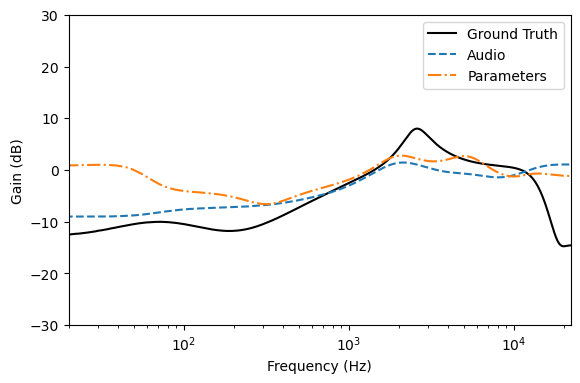

In [49]:
#print(AFX_Chain.controls_ranges)
#x = torch.zeros(1, 1, sr_hz).to(device)
#x[0,0,0]=1
compute=True
exports={}
if compute:

    x=x.to(device)


    outputs = {}

    with torch.no_grad():
        q = torch.rand(batch_size, AFX_Chain.num_controls).to(device)
        #q = torch.Tensor([[
        #    .5, .2, .3,
        #    .3, .8, .8,
        #    .5, .3, .9,
        #    .5, .5, .5,
        #    .1, .2, .9,
        #]]).to(device)


        imp = torch.zeros(batch_size, 1, sr_hz).to(device)
        for i in range(batch_size):
            imp[i,0,0]=1


        y = AFX_Chain(x, q =q)
        
        outputs['Ground Truth'] = AFX_Chain(imp, q =q).detach().cpu().numpy()
        
        exports['Input'] = x.clone().detach().cpu().numpy()
        exports['GT'] = y.clone().detach().cpu().numpy()

        for label,controller in controllers_dict.items():
            qHat = controller(y)
            print(label)
            print(f'Parameters metric: {round(torch.mean(l2(q, qHat)).item(), 4)}')
            
            yHat = AFX_Chain(x, q =qHat)
            yHat = yHat/torch.sqrt(torch.mean(torch.square(yHat), axis=2, keepdim=True))
            exports[label] = yHat.detach().cpu().numpy()
            
            print(f'Mel metric: {round(torch.mean(Mel(y, yHat)).item(), 4)}')

            yHat = AFX_Chain(imp, q =qHat)
            yHat = yHat/torch.sqrt(torch.sum(torch.square(yHat), axis=2, keepdim=True))
            outputs[label] = yHat.detach().cpu().numpy()

max_val = 0
for label in exports.keys():
    exports[label] = exports[label]/RMS(exports[label])
    max_val = max(max_val, np.amax(np.abs(exports[label])))

for label in exports.keys():
    exports[label] = exports[label]/max_val

#for label, sig in exports.items():
#    scipy.io.wavfile.write(filename=f'Exports/EQ/{label}.wav', rate=44100, data=sig)

    
plt.figure(figsize = (15*cm, 10*cm))
for label, sig in outputs.items():

    sig = sig[0,0,:]

    x_fft = np.fft.rfft(sig)
    f = np.fft.rfftfreq(n=len(sig), d = 1/44100)

    line = plt.plot(f, dB20(x_fft/RMS(sig)), styles[label], label = label)
plt.semilogx()
plt.xlim(20, 22050)
plt.ylim(-30, 30)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.legend()
plt.tight_layout()
#plt.savefig("Images/EQ_Matching.svg")
plt.show()


    #plt.plot(q_np*30-15)
    #plt.plot(qHat_np*30-15)
    #plt.show()